In [1]:
import pandas as pd
df = pd.read_csv('c:/data/time/pollution.csv', index_col=0)
df.head()

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


<AxesSubplot:>

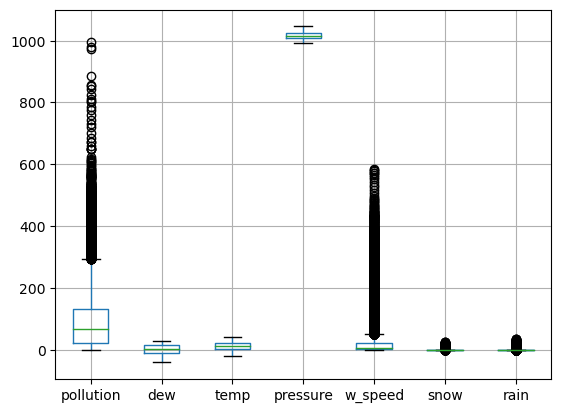

In [2]:
#전처리 전 박스플롯
df.boxplot()

In [3]:
#w_dir변수 정수 인코딩
from sklearn.preprocessing import LabelEncoder
import numpy as np
values = df.values
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
values = values.astype('float32')
np.unique(values[:, 4])

array([0., 1., 2., 3.], dtype=float32)

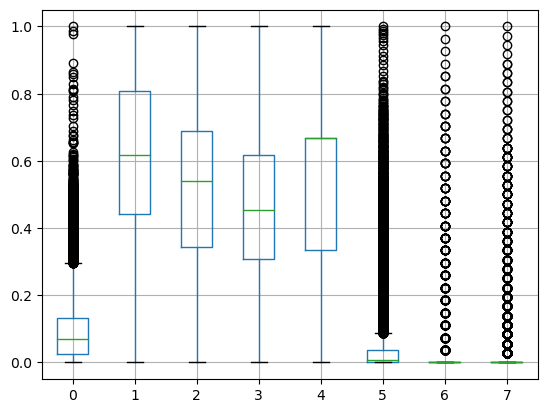

In [4]:
#스케일링
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).boxplot()
plt.show()

In [5]:
#쉬프트
def shift(train):
    timestep = 4
    X = []
    y = []
    for i in range(timestep, len(train)):
        X.append(train[i-timestep:i, :]) # pollution ~ rain
        y.append(train[i, 0:1]) # pollution
    return X, y

In [6]:
X, y = shift(scaled)
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(43796, 4, 8)
(43796, 1)


In [7]:
#학습용, 검증용으로 분할(4년:1년)
n_train = int(len(X) * 0.2) + 1
X_train, X_test = X[n_train:, ], X[:n_train, ]
print(X_train.shape, X_test.shape)
y_train, y_test = y[n_train:, ], y[:n_train, ]
print(y_train.shape, y_test.shape)

(35036, 4, 8) (8760, 4, 8)
(35036, 1) (8760, 1)


In [8]:
#모델 생성
# return_sequences=False: 기본값, 마지막 스텝만 내보내는 옵션
# return_sequences=True: 모든 스텝에 내보내는 옵션(LSTM을 여러층으로 만들 경우 사용)
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             11800     
                                                                 
 dropout (Dropout)           (None, 4, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [9]:
#모델 학습
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
876/876 [==============================] - 13s 10ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 2/10
876/876 [==============================] - 8s 9ms/step - loss: 0.0014 - val_loss: 5.9211e-04
Epoch 3/10
876/876 [==============================] - 8s 9ms/step - loss: 0.0011 - val_loss: 5.0992e-04
Epoch 4/10
876/876 [==============================] - 8s 9ms/step - loss: 9.5135e-04 - val_loss: 5.1453e-04
Epoch 5/10
876/876 [==============================] - 8s 9ms/step - loss: 9.2201e-04 - val_loss: 5.0916e-04
Epoch 6/10
876/876 [==============================] - 8s 9ms/step - loss: 9.1757e-04 - val_loss: 5.1354e-04
Epoch 7/10
876/876 [==============================] - 8s 9ms/step - loss: 8.9259e-04 - val_loss: 5.0897e-04
Epoch 8/10
876/876 [==============================] - 8s 9ms/step - loss: 9.0850e-04 - val_loss: 5.3504e-04
Epoch 9/10
876/876 [==============================] - 8s 9ms/step - loss: 8.6901e-04 - val_loss: 5.3112e-04
Epoch 10/10
876/876 [=====================

In [10]:
#모델 평가
from sklearn.metrics import mean_squared_error
pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
rmse

274/274 [==============================] - 2s 3ms/step


0.030598039

In [11]:
d = scaled[:n_train, :]
y_predicted = np.concatenate((pred, d[:n_train, 1:]), axis=1)
y_tested = np.concatenate((y_test, d[:n_train, 1:]), axis=1)

In [12]:
#실제값 오차
y_predicted = scaler.inverse_transform(y_predicted)
y_tested = scaler.inverse_transform(y_tested)
y_predicted = y_predicted[:, 0:1]
y_tested = y_tested[:, 0:1]

In [13]:
mse = mean_squared_error(y_tested, y_predicted)
print('RMSE', np.sqrt(mse))

RMSE 30.414454


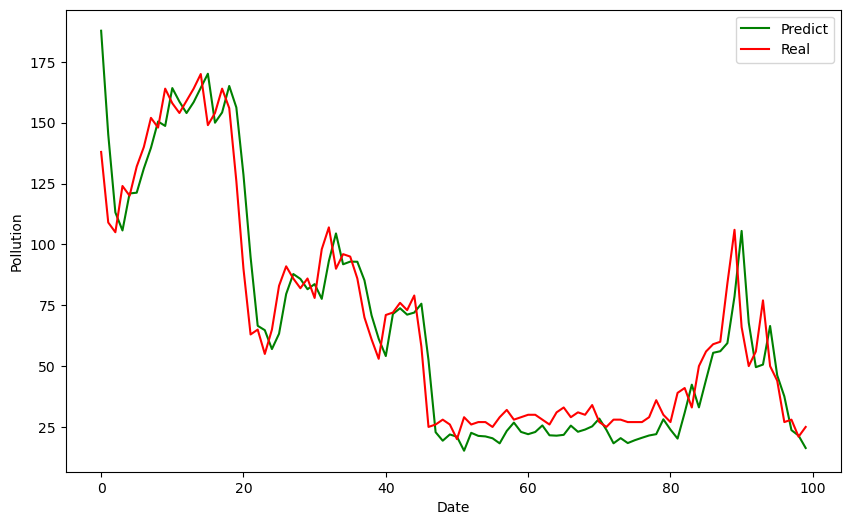

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_predicted[:100, :], color='g', label='Predict')
plt.plot(y_tested[:100, :], color='r', label='Real')
plt.xlabel('Date')
plt.ylabel('Pollution')
plt.legend()
plt.show()